In [4]:
!pip install timm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import os
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import random
import copy
import timm  # Import timm for Inception v4
import math

# Define the dataset path
data_dir = '/content/drive/My Drive/Dataset'

# Set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)


In [7]:
def imshow(img, title=None):
    """Show an image with matplotlib."""
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.show()

def show_batch(dataloader, class_names):
    """Show a batch of images from the dataloader."""
    # Get a batch of images
    inputs, labels = next(iter(dataloader))

    # Make a grid from the batch
    grid = torchvision.utils.make_grid(inputs)

    # Show the images
    imshow(grid, title=[class_names[x] for x in labels])

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


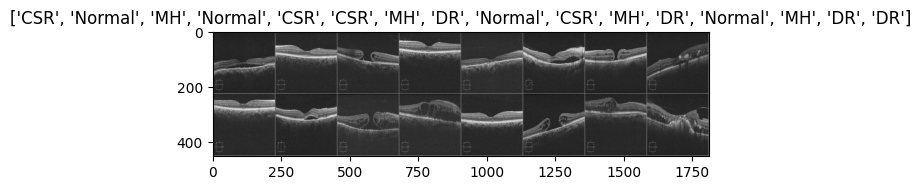

In [8]:
data_transforms = {
    'train': transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=15),  # Rotate by up to 15 degrees
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

# Load the dataset
data_dir = '/content/drive/My Drive/Dataset'
full_dataset = datasets.ImageFolder(data_dir, transform=data_transforms['train'])
class_names = full_dataset.classes

# Function to split dataset by class sequentially
def split_dataset_by_class_sequential(dataset, test_ratio=0.2, val_ratio=0.1):
    train_indices = []
    val_indices = []
    test_indices = []
    targets = dataset.targets

    for class_index in range(len(dataset.classes)):
        class_indices = [i for i, target in enumerate(targets) if target == class_index]
        class_size = len(class_indices)
        class_test_size = int(math.ceil(class_size * test_ratio))
        class_val_size = int(math.ceil((class_size - class_test_size) * val_ratio))

        class_test_indices = class_indices[:class_test_size]
        class_val_indices = class_indices[class_test_size:class_test_size + class_val_size]
        class_train_indices = class_indices[class_test_size + class_val_size:]

        test_indices.extend(class_test_indices)
        val_indices.extend(class_val_indices)
        train_indices.extend(class_train_indices)

    return train_indices, val_indices, test_indices

# Split the dataset
train_indices, val_indices, test_indices = split_dataset_by_class_sequential(full_dataset)

# Create train, validation, and test datasets
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)
test_dataset = Subset(full_dataset, test_indices)

# Update transforms for validation and test sets
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']
test_dataset.dataset.transform = data_transforms['test']

# Create data loaders
batch_size = 16
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
}

dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset),
    'test': len(test_dataset)
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Display sample images from the training set
show_batch(dataloaders['train'], class_names)


In [9]:
# Load Pretrained Inception v4 Model from timm
model = timm.create_model('inception_v4', pretrained=True)

# Replace the final layer to match the number of classes
num_ftrs = model.get_classifier().in_features
model.reset_classifier(num_classes=len(class_names))
model = model.to(device)

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training Function with Early Stopping
def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=10, patience=3):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                epochs_no_improve = 0
            elif phase == 'val':
                epochs_no_improve += 1

        if epochs_no_improve == patience:
            print('Early stopping!')
            break

    print(f'Best val Acc: {best_acc:4f}')
    model.load_state_dict(best_model_wts)
    return model


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/171M [00:00<?, ?B/s]

In [10]:
# Train the model
model = train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=10)

# Save the model
torch.save(model.state_dict(), '/content/drive/My Drive/inception_v4_model.pth')

# Evaluate on test set
model.eval()
running_corrects = 0

for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

    running_corrects += torch.sum(preds == labels.data)

test_acc = running_corrects.double() / dataset_sizes['test']
print(f'Test Acc: {test_acc:.4f}')

Epoch 0/9
----------
train Loss: 0.9306 Acc: 0.6527
val Loss: 36.3651 Acc: 0.5306
Epoch 1/9
----------
train Loss: 0.6424 Acc: 0.8030
val Loss: 2.2342 Acc: 0.6122
Epoch 2/9
----------
train Loss: 0.4677 Acc: 0.8744
val Loss: 1.5500 Acc: 0.6327
Epoch 3/9
----------
train Loss: 0.4989 Acc: 0.8744
val Loss: 0.7241 Acc: 0.7551
Epoch 4/9
----------
train Loss: 0.5530 Acc: 0.8596
val Loss: 0.6864 Acc: 0.7755
Epoch 5/9
----------
train Loss: 0.2643 Acc: 0.9039
val Loss: 0.3364 Acc: 0.8776
Epoch 6/9
----------
train Loss: 0.1889 Acc: 0.9433
val Loss: 0.2599 Acc: 0.9184
Epoch 7/9
----------
train Loss: 0.1002 Acc: 0.9754
val Loss: 0.3894 Acc: 0.8571
Epoch 8/9
----------
train Loss: 0.0934 Acc: 0.9754
val Loss: 0.2987 Acc: 0.9184
Epoch 9/9
----------
train Loss: 0.0336 Acc: 0.9926
val Loss: 0.3479 Acc: 0.9388
Best val Acc: 0.938776
Test Acc: 0.9658
